<a href="https://colab.research.google.com/github/nvhieu0163/ComparativeOpinionMining_KLTN2023/blob/main/1_CSI_using_phoBERT_trinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!pip install py_vncorenlp
!pip install transformers
!pip install tokenizers

  Using cached py_vncorenlp-0.1.4-py3-none-any.whl
  Using cached pyjnius-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)


## Load data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final"

/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final


In [ ]:
df125 = pd.read_csv("file125_last_update.csv")
df34 = pd.read_csv("file34_last_update.csv")


Chuyển về nhị phân

In [ ]:
df_total =  pd.concat([df125, df34], ignore_index = True)

# 3 labels
df_total.loc[df_total["CSI"] == 1, "CSI"] = 2   # gradable comparative là 2
df_total.loc[df_total["CSI"] == 3, "CSI"] = 2   # non comparative là 0
df_total.loc[df_total["CSI"] == 4, "CSI"] = 1   # non gradable comparative là 1

In [ ]:
df_total

,blog_idx,stc_idx,main,CSI
0,220,50,"Đặc biệt, dải đèn LED định vị ban ngày của chi...",0
1,220,51,"Tuy nhiên, nhược điểm của cụm đèn này là dễ bá...",0
2,220,52,"Bên phía đối diện, Kia Sorento 2021 cũng mang ...",1
3,220,53,Cụm đèn pha trên chiếc xe do Thaco lắp ráp dùn...,0
4,220,54,"Nhìn vào những thông số kích thước trên, VinFa...",2
...,...,...,...,...
9995,275,29695,Động cơ QX60 được kết hợp với hộp số vô cấp tự...,0
9996,275,29696,"Cũng tương tự Nissan Murano và Pathfinder, độn...",2
9997,275,29697,mẫu SUV hạng sang này được chia thành 3 phiên ...,0
9998,275,29698,"Phiên bản động cơ Prestige S Line 3.0T V6 3,0 ...",0


<Axes: >

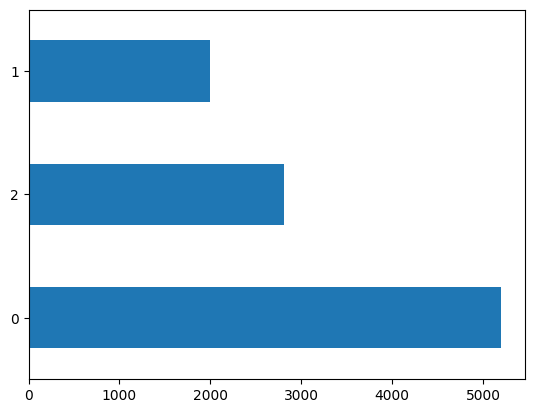

In [ ]:
df_total["CSI"].value_counts().plot.barh()

## Tokenize and Encode for BERT example

In [ ]:
import py_vncorenlp

py_vncorenlp.download_model(save_dir='/content/drive/MyDrive/NCKH_KLTN/Thuc_nghiem/vn_corenlp_2')

VnCoreNLP model folder /content/drive/MyDrive/NCKH_KLTN/Thuc_nghiem/vn_corenlp_2 already exists! Please load VnCoreNLP from this folder!


In [ ]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive/NCKH_KLTN/Thuc_nghiem/vn_corenlp_2')

In [ ]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# text = 'Mazda CX3 2021 có 3 phiên bản Deluxe, Luxury và Premium, giá bán lần lượt là: 629, 669 và 709 triệu đồng'
# tk_text = rdrsegmenter.word_segment(text)  # Bước quan trọng của phoBERT là cần tokenize trước

# bert_input = tokenizer(tk_text, padding='max_length', max_length = 30, truncation=True, return_tensors="pt")

# print(bert_input['input_ids'])
# print(bert_input['token_type_ids'])
# print(bert_input['attention_mask'])

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
# print(tk_text)

In [ ]:
# decode_text = tokenizer.decode(bert_input.input_ids[0])
# print(decode_text)

## Train test dev split

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


def get_all(y_pred, y_label, average):
    return [get_acc(y_label, y_pred, average), recall_score(y_label, y_pred, average=average), precision_score(y_label, y_pred, average=average), f1_score(y_label, y_pred, average=average)]

def get_recall(y_pred, y_label, average):
    return recall_score(y_label, y_pred, average=average)

def get_precision(y_pred, y_label, average):
    return precision_score(y_label, y_pred, average=average)

def get_f1(y_pred, y_label, average):
    return f1_score(y_label, y_pred, average=average)

def get_acc(y_pred, y_label, average):
    return accuracy_score(y_label, y_pred)

In [ ]:
token_main = []
for stc in df_total["main"]:
    a = rdrsegmenter.word_segment(stc)
    assert len(a) == 1, 'Độ dài câu văn khác 1'
    token_main.append(a[0])

df_total["main_token"] = token_main

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_total.main_token, df_total.CSI, test_size=0.2, random_state=42)

## Dataset and DataLoader

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

class BERT_Dataset(torch.utils.data.Dataset):

    def __init__(self, X, y):

        self.labels = list(y)
        self.texts = [tokenizer(stc, padding='max_length', max_length = 256, truncation=True, return_tensors="pt") for stc in list(X)]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Text(0.5, 9.444444444444438, 'Token Count')

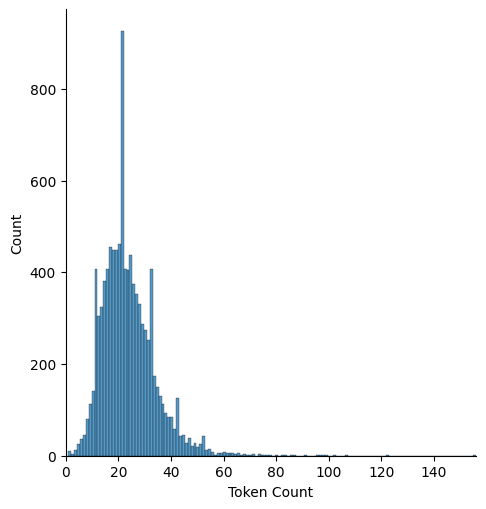

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess


all_data = X_train.tolist() + X_test.tolist()

all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=False) for text in all_data]

token_lens = [len(text) for text in encoded_text]

sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

## Model

In [ ]:
from torch import nn
from transformers import AutoModel

class BertClassifier(nn.Module):

    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        self.dropout = nn.Dropout(p = 0.1)
        self.linear = nn.Linear(self.bert.config.hidden_size, 3)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        last_hidden_state, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
# import sys

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, x, y, learning_rate, epochs, batchsize):

    train = BERT_Dataset(x, y)
    # val = BERT_Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batchsize, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val, batch_size=batchsize)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        y_pred_train = torch.empty((batchsize), dtype=torch.int64).to(device)
        y_label_train = torch.empty((batchsize), dtype=torch.int64).to(device)
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            # print(output.argmax(dim=1))
            y_pred_train = torch.cat((y_pred_train, output.argmax(dim=1)), 0)
            y_label_train = torch.cat((y_label_train, train_label), 0)

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # y_pred_val = torch.empty((batchsize), dtype=torch.int64).to(device)
        # y_label_val = torch.empty((batchsize), dtype=torch.int64).to(device)
        # total_loss_val = 0

        # with torch.no_grad():

        #     for val_input, val_label in val_dataloader:

        #         val_label = val_label.to(device)
        #         mask = val_input['attention_mask'].to(device)
        #         input_id = val_input['input_ids'].squeeze(1).to(device)

        #         output = model(input_id, mask)

        #         batch_loss = criterion(output, val_label.long())
        #         total_loss_val += batch_loss.item()

        #         # print(output)
        #         y_pred_val = torch.cat((y_pred_val, output.argmax(dim=1)), 0)
        #         y_label_val = torch.cat((y_label_val, train_label), 0)

        print(
            f'Epochs: {epoch_num + 1} \
            | Train Loss: {total_loss_train/len(y): .3f} \
            | Train F1-score: {f1_score(y_label_train[batchsize:].cpu(), y_pred_train[batchsize:].cpu(), average=None)}')
            # | Val Loss: {total_loss_val/len(val_data): .3f} \
            # | Val Measure: {all_measure_val}')

In [ ]:
model = BertClassifier()
EPOCHS = 5
LR = 1e-6
BATCH_SIZE = 8

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
train(model=model, x = X_train, y = y_train, learning_rate = LR, epochs = EPOCHS, batchsize = BATCH_SIZE)

100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


Epochs: 1             | Train Loss:  0.107             | Train F1-score: [0.76013226 0.14773363 0.52205072]


100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


Epochs: 2             | Train Loss:  0.057             | Train F1-score: [0.91990632 0.71651712 0.80296563]


100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


Epochs: 3             | Train Loss:  0.043             | Train F1-score: [0.94511251 0.77669291 0.8409399 ]


100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


Epochs: 4             | Train Loss:  0.036             | Train F1-score: [0.95723014 0.80149115 0.86332882]


100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


Epochs: 5             | Train Loss:  0.031             | Train F1-score: [0.96635939 0.83468497 0.88673722]


In [ ]:
from sklearn.metrics import classification_report
def evaluate(model, x, y):

    test = BERT_Dataset(x, y)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    y_pred_test = torch.empty((BATCH_SIZE), dtype=torch.int64).to(device)
    y_label_test = torch.empty((BATCH_SIZE), dtype=torch.int64).to(device)


    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            y_pred_test = torch.cat((y_pred_test, output.argmax(dim=1)), 0)
            y_label_test = torch.cat((y_label_test, test_label), 0)

    # all_measure_test = get_all(y_label_test[BATCH_SIZE:].cpu(), y_pred_test[BATCH_SIZE:].cpu(), None)
    # print(f'Test Measue: {all_measure_test}')
    print(classification_report(y_label_test[BATCH_SIZE:].cpu(), y_pred_test[BATCH_SIZE:].cpu(), digits=4))

    return [y_label_test[BATCH_SIZE:], y_pred_test[BATCH_SIZE:]]

In [ ]:
true_list, prediction_list = evaluate(model, X_test, y_test)

              precision    recall  f1-score   support

           0     0.9153    0.9526    0.9336      1033
           1     0.7893    0.7395    0.7636       380
           2     0.8559    0.8296    0.8426       587

    accuracy                         0.8760      2000
   macro avg     0.8535    0.8406    0.8466      2000
weighted avg     0.8740    0.8760    0.8746      2000



In [ ]:
cd "/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final"

/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final


In [ ]:
data_test = {
    'stc' : X_test.tolist(),
    'pred' : prediction_list.tolist(),
    'label' : true_list.tolist()
}

df_test = pd.DataFrame(data_test)
df_test.to_csv('./data_prediction/CSI_test_trinary.csv', header = True, index = False)